# README

This notebook is used to demonstrate performance of my generic agent. It's tested on the GAIA benchmark. 

GAIA is a benchmark designed to evaluate AI assistants on real-world tasks that require a combination of core capabilities—such as reasoning, multimodal understanding, web browsing, and proficient tool use.You can find more information on [huggingface](https://huggingface.co/learn/agents-course/en/unit4/what-is-gaia).


This agent currently solves about 30% of GAIA level 1 tasks & Ranked 150 out of 5165 on the [huggingface leaderboard](https://huggingface.co/spaces/huggingface-team/gaia-leaderboard) (as of July 8, 2025).

## Load Data

In [1]:
import json

# Load the metadata.jsonl file
with open('data/metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)

### Data Analyses

Here we analyze the data in order to find what tools we need to build a robust agent

In [10]:
import random

random_samples = random.sample(json_QA, 3)
for sample in random_samples:
    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")
    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")
    print(f"  ├── Steps: ")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")
    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")
    print(f"  ├── Tools:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")
    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")
print("=" * 50)

Task ID: 0a65cb96-cb6e-4a6a-8aae-c1084f613456
Question: During the first week of August 2015, one of the NASA Astronomy Pictures of the Day shows the lights of a city on the horizon. The namesake of this city also has a landmark building in Chicago named after him. What is the name of the architectural firm that designed this landmark building? Give the first name appearing in the name of the firm as of June 2023.
Level: 2
Final Answer: Holabird
Annotator Metadata: 
  ├── Steps: 
  │      ├── 1. Use search engine to search for "NASA Astronomy Pictures of the Day August 2015".
  │      ├── 2. Navigate to the NASA Astronomy Picture of the Day Archive.
  │      ├── 3. Open the Astronomy Picture of the Day for 2015 August 1-7.
  │      ├── 4. Read the descriptions to check which picture shows the lights of a city on the horizon (2015 August 3) and note the name of the city (Marquette, Michigan, USA).
  │      ├── 5. Go to the Wikipedia article for Marquette, Michigan and note that the city

## Graph Implementation

Here we build the agent graph with LangGraph to solve those tasks!

In [11]:
system_prompt = """
You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
==========================
Here is a few examples showing you how to answer the question step by step.
"""
for i, samples in enumerate(random_samples):
    system_prompt += f"\nQuestion {i+1}: {samples['Question']}\nSteps:\n{samples['Annotator Metadata']['Steps']}\nTools:\n{samples['Annotator Metadata']['Tools']}\nFinal Answer: {samples['Final answer']}\n"
system_prompt += "\n==========================\n"
system_prompt += "Now, I will ask you a question. Please answer the question step by step. Report your thoughts, and finish your answer with the following template: \n"
system_prompt += "FINAL ANSWER: [YOUR FINAL ANSWER]. \n"
system_prompt += "YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, Apply the rules above for each element (number or string), ensure there is exactly one space after each comma.\n"
system_prompt += "Your answer should only start with 'FINAL ANSWER: ', then follows with the answer.\n"

# save the system_prompt to a file
with open('system_prompt.txt', 'w') as f:
    f.write(system_prompt)

In [4]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()
print(system_prompt)


You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
Here is a few examples showing you how to answer the question step by step.

Question 1: The object in the British Museum's collection with a museum number of 2012,5015.17 is the shell of a particular mollusk species. According to the abstract of a research article published in Science Advances in 2021, beads made from the shells of this species were found that are at least how many thousands of years old?
Steps:
1. Use search engine to search for "British Museum search collection" and navigate to the British Museum's collection search webpage.
2. Select "Museum number" as search field and "2012,5015.17" in text box, then run search.
3. Open the page for the single result and note that the de

In [5]:
import os
from dotenv import load_dotenv
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from tools.searchtools import wiki_search, web_search, arxiv_search
from tools.mathtools import multiply, add, subtract, divide, modulus
from tools.documenttools import download_file_from_url, save_file, extract_text_from_image, analyze_csv_file, analyze_excel_file, construct_question_related_file_url
from tools.audiotools import transcribe_audio
from tools.codetools import execute_code_multilang

# Define the retriever from supabase
load_dotenv()



tools = [
    multiply,
    add,
    subtract,
    divide,
    modulus,
    wiki_search,
    web_search,
    arxiv_search,
    construct_question_related_file_url,
    download_file_from_url,
    save_file,
    extract_text_from_image,
    analyze_csv_file,
    analyze_excel_file,
    execute_code_multilang,
    transcribe_audio,
]

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url='https://openrouter.ai/api/v1'
)
llm_with_tools = llm.bind_tools(tools)

In [6]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()


# System message
sys_msg = SystemMessage(content=system_prompt)

# Node
def assistant(state: MessagesState):
    """Assistant node"""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Compile graph
graph = builder.compile()

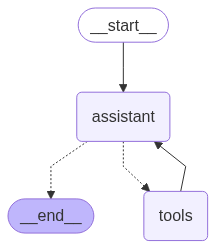

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [16]:
import requests

random_question = requests.get(
    "https://agents-course-unit4-scoring.hf.space/random-question").json()

question = random_question["question"]
question_id = random_question["task_id"]
file_name = random_question["file_name"]

print(question)
print(question_id)
print(file_name)

messages = [HumanMessage(content=question)]
if file_name:
    messages.append(HumanMessage(content=f"Question id is: {question_id}"))

messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

The attached Excel file contains the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.
7bd855d8-463d-4ed5-93ca-5fe35145f733
7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
================================ Human Message =================================

The attached Excel file contains the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.
================================ Human Message =================================

Question id is: 7bd855d8-463d-4ed5-93ca-5fe35145f733
================================== Ai Message ==================================
Tool Calls:
  construct_question_related_file_url (call_Iy1HcZJ9qYVP25M7Kh9WdPw9)
 Call ID: call_Iy1HcZJ9qYVP25M7Kh9WdPw9
  Args:
    question_id: 7bd855d8-463d-4ed5-93ca-5fe35145f733
===

## debug


In [8]:
question = "Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.\n\nIn your response, please only list the ingredients, not any measurements. So if the recipe calls for \"a pinch of salt\" or \"two cups of ripe strawberries\" the ingredients on the list would be \"salt\" and \"ripe strawberries\".\n\nPlease format your response as a comma separated list of ingredients. Also, please alphabetize the ingredients."
question_id = "Question id is: 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3"
messages = [HumanMessage(content=question), HumanMessage(content=question_id)]
messages = graph.invoke({"messages": messages})

In [9]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.

In your response, please only list the ingredients, not any measurements. So if the recipe calls for "a pinch of salt" or "two cups of ripe strawberries" the ingredients on the list would be "salt" and "ripe strawberries".

Please format your response as a comma separated list of ingredients. Also, please alphabetize the ingredients.
================================

1. 刘德华在 2000 - 2010 十年间总共有多少张白金唱片？
2. xxxx 视频中，1:00 - 1:10 之间总共出现了多少只企鹅？
3. 在疯狂的外星人这部电影中扮演耿浩的演员，他在疯狂的石头中扮演的角色名叫什么？
4. 我的朋友电话留言告诉我了她做 xxx 菜的经历。现在我想要复刻这道菜，请帮我听这个语音，并列出我需要购买哪些原料？
5. 丁俊晖在2019 英锦赛上总共拿下了多少分？
6. 在 attention is all you need 这篇论文底部的引用中，第 35 条引用的一作目前在哪里工作？

cornstarch, freshly squeezed lemon juice, granulated sugar, pure vanilla extract, ripe strawberries